# ICESat-2 tracks and profile plot 

## Part of the scripts were adapted from Sliderule tutorials available at: 

https://slideruleearth.io/web/rtd/tutorials/user/first_request.html

https://slideruleearth.io/web/rtd/tutorials/user.html 

https://slideruleearth.io/web/rtd/getting_started/Examples.html

## 1. Initiate Sliderule and define input and output directories

In [2]:
import sliderule
from sliderule import icesat2, gedi, earthdata
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
icesat2.init("slideruleearth.io", verbose=True)
gedi.init()

In [4]:
# Directory where your area of interest .geojson is stored
dir_shp = 'C:/Users/rvieiral/OneDrive - NASA/Documents/Projects/Cibele/FireEOreview/Figures/scripts/data/shp'
# Directory where the output figures will be saved
dir_figures = 'C:/Users/rvieiral/OneDrive - NASA/Documents/Projects/Cibele/FireEOreview/Figures'

## 2. Upload area of interest geojason file

In [5]:
# Define path to the .geojson file
poly_fn =  os.path.join(dir_shp,'mg1_veg.geojson')
# Uploaded it  as a sliderule region
region = sliderule.toregion(poly_fn)
# print(region)

## 3. Get ICESat-2 tracks

In [7]:
# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4

# Define main parameters to extract
parms = {
    # processing parameters
    "srt": icesat2.SRT_LAND,
    "len": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": -2, 
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0)
}


# Define ICESat-2 data release
release = '005'

# Define region of interest
poly = region["poly"]

# Define time bounds for CMR query
time_start = '2019-11-14'
time_end = '2019-11-15'


# Search  granule for the region of interest
granules_list = earthdata.cmr(short_name='ATL03', 
                              polygon=poly, 
                              time_start=time_start, 
                              time_end=time_end, 
                              version=release)

# create an empty geodataframe
parms["poly"] = poly

In [10]:
%%time
# create an empty geodataframe
icesat_tracks = icesat2.atl03sp(parms, resources=granules_list)
icesat_tracks.head()

CPU times: total: 2.5 s
Wall time: 7.09 s


,pair,solar_elevation,sc_orient,rgt,segment_dist,track,segment_id,cycle,background_rate,height,...,atl08_class,landcover,yapc_score,x_atc,y_atc,relief,quality_ph,snowcover,geometry,spot
time,,,,,,,,,,,,,,,,,,,,,
2022-11-06 07:35:09.062368000,0,-8.886476,1,711,2.221711e+07,2,1108887,17,10343.90363,872.548645,...,2,255,67,-8.368109,-5057.684570,0.0,0,255,POINT (-43.64091 -19.29823),4
2022-11-06 07:35:09.062468096,0,-8.886476,1,711,2.221711e+07,2,1108887,17,10343.90363,871.346497,...,1,255,75,-7.653037,-5057.694336,0.0,0,255,POINT (-43.64091 -19.29823),4
2022-11-06 07:35:09.062668032,0,-8.886476,1,711,2.221711e+07,2,1108887,17,10343.90363,871.700928,...,1,255,81,-6.231349,-5057.683594,0.0,0,255,POINT (-43.64091 -19.29825),4
2022-11-06 07:35:09.062767872,0,-8.886476,1,711,2.221711e+07,2,1108887,17,10343.90363,1352.457275,...,4,255,0,-7.086267,-5052.503418,0.0,0,255,POINT (-43.64086 -19.29824),4
2022-11-06 07:35:09.063768064,0,-8.886476,1,711,2.221711e+07,2,1108887,17,10343.90363,872.682922,...,2,255,0,1.592691,-5057.635742,0.0,0,255,POINT (-43.64092 -19.29832),4


## 4. Checking  rgt, track, distance and height values to select a track to plot 

In [20]:
# icesat_tracks.columns
# Check unique values in the 'rgt' column
unique_rgt = icesat_tracks['rgt'].unique()

# Check unique values in the 'track' column
unique_track = icesat_tracks['track'].unique()


# Check the range of values in the 'x_atc' column
x_atc_min = icesat_tracks['x_atc'].min()
x_atc_max = icesat_tracks['x_atc'].max()

# Check the range of values in the 'segment_dist' column
segment_dist_min = icesat_tracks['segment_dist'].min()
segment_dist_max = icesat_tracks['segment_dist'].max()


# Check the range of values in the 'height' column
height_min = icesat_tracks['height'].min()
height_max = icesat_tracks['height'].max()


# Print the unique values
print("Unique values in 'rgt' column:", unique_rgt)
print("Unique values in 'track' column:", unique_track)
# Print the ranges
print("Range of 'x_atc' values: ({}, {})".format(x_atc_min, x_atc_max))
print("Range of 'segment_dist' values: ({}, {})".format(segment_dist_min, segment_dist_max))
print("Range of 'height' values: ({}, {})".format(height_min, height_max))

Unique values in 'rgt' column: [711 322]
Unique values in 'track' column: [2]
Range of 'x_atc' values: (-29.895118713378906, 9.99914264678955)
Range of 'segment_dist' values: (22217113.227770846, 37997904.74467364)
Range of 'height' values: (238.06443786621094, 2048.48046875)


## 5. Filtering a geodataframe to select a single track

In [21]:
# Function to filter the geodatafame with icesat tracks
def reduce_dataframe(icesat_tracks, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = icesat_tracks.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    return D3

In [22]:
beam_type = 'strong'
# Define metric projection
project_srs = "EPSG:32723"
# Filter ICESat-2 track
icesat2_track = reduce_dataframe(icesat_tracks, 
                                 RGT=711, 
                                 track=2, 
                                 beam='strong', 
                                 crs=project_srs
                                )
icesat2_track.head()

,pair,solar_elevation,sc_orient,rgt,segment_dist,track,segment_id,cycle,background_rate,height,...,atl08_class,landcover,yapc_score,x_atc,y_atc,relief,quality_ph,snowcover,geometry,spot
time,,,,,,,,,,,,,,,,,,,,,
2022-11-06 07:35:09.404568320,1,-8.886016,1,711,2.221711e+07,2,1108887,17,23568.274157,877.350891,...,1,255,233,-9.342755,-5149.628906,0.0,0,255,POINT (642706.797 7865624.773),3
2022-11-06 07:35:09.404568320,1,-8.886016,1,711,2.221711e+07,2,1108887,17,23568.274157,877.680237,...,1,255,248,-9.342142,-5149.625488,0.0,0,255,POINT (642706.801 7865624.772),3
2022-11-06 07:35:09.404568320,1,-8.886016,1,711,2.221711e+07,2,1108887,17,23568.274157,877.726807,...,1,255,247,-9.342142,-5149.625000,0.0,0,255,POINT (642706.801 7865624.772),3
2022-11-06 07:35:09.404668160,1,-8.886016,1,711,2.221711e+07,2,1108887,17,23568.274157,877.679077,...,1,255,248,-8.634949,-5149.627441,0.0,0,255,POINT (642706.723 7865624.069),3
2022-11-06 07:35:09.404768000,1,-8.886016,1,711,2.221711e+07,2,1108887,17,23568.274157,877.687378,...,1,255,248,-7.927139,-5149.629395,0.0,0,255,POINT (642706.645 7865623.366),3


## 6. Plot and save ICESat-2 track

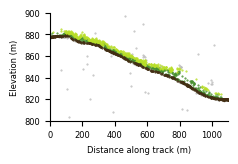

In [44]:
# Define size of the image here (width, height)
plt.figure(figsize=[2.3,1.4])

# Define the desired font size
font_size = 6

# Set global font size for titles, labels, and tick labels
plt.rcParams.update({'font.size': font_size})


# Define color of each class
colors={0:['#bdbdbd', 'Noise'], #f0f0f0 #bdbdbd gray
        4:['#bdbdbd','Unclassified'],  
        2:['#489030','Vegetation'], 
        3:['#B8DE29', 'Canopy top'], #B8DE29
        1:['#422E13', 'Ground']}

# Get the track start distance
d0=np.min(icesat2_track['segment_dist'])

# Calculate distances and plot
for class_val, color_name in colors.items():
    ii=icesat2_track['atl08_class']==class_val
    
    plt.plot(icesat2_track['segment_dist'][ii]+icesat2_track['x_atc'][ii]-d0, 
             icesat2_track['height'][ii],
             'o', 
             markersize=0.5, 
             color=color_name[0], 
             label=color_name[1]
            )
    
# hl=plt.legend(loc=3, frameon=False, markerscale=5)
plt.gca().set_xlim([0, 1100])
plt.gca().set_ylim([800, 900])

# plt.gca().set_xlim([375, 600])
# plt.gca().set_ylim([840, 880])

# Remove the right and top borders
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust the line width of the left and bottom borders
# ax.spines['left'].set_linewidth(0.5)  # Set a thinner line width
# ax.spines['bottom'].set_linewidth(0.5)  # Set a thinner line width


plt.ylabel('Elevation (m)')
plt.xlabel('Distance along track (m)');

# Export the plot as a TIFF image
icesat2_track_path = os.path.join(dir_figures, 'GediIcesat',
                                  'icesat2_track.tif')
plt.savefig(icesat2_track_path, 
            dpi=300, bbox_inches='tight', format='tiff')


## 7. Plot ICESat-2 profile for a segment

In [26]:
# Calculate the minimum value of 'segment_dist'
d0 = icesat2_track['segment_dist'].min()

# Create the 'along_track' column using the specified calculation
icesat2_track['along_track'] = (icesat2_track['segment_dist'] + icesat2_track['x_atc'] - d0)

segment_start = 250
segment_end = 450
# Filter 'icesat2_track' for values between 375 and 400 in the 'along_track' column
icesat2_clip = icesat2_track[(icesat2_track['along_track'] >= segment_start) & (icesat2_track['along_track'] <= 450)]


In [27]:
# Check the range of values in the 'along_track' column
along_track_min = icesat2_clip['along_track'].min()
along_track_max = icesat2_clip['along_track'].max()

# Check the range of values in the 'height' column
min_elevation = icesat2_clip['height'].min()
max_elevation = icesat2_clip['height'].max()



print("Range of 'along_track' values: ({}, {})".format(along_track_min, along_track_max))
print("Range of 'height' values: ({}, {})".format(min_elevation, max_elevation))




Range of 'along_track' values: (250.43207612633705, 449.95028741285205)
Range of 'height' values: (322.6165466308594, 1453.9891357421875)


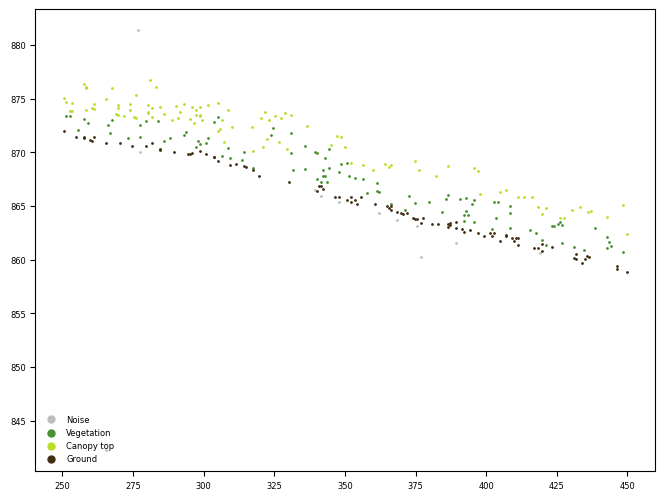

In [29]:
# Plot segement
plt.figure(figsize=[8,6])

colors={0:['#bdbdbd', 'Noise'], #f0f0f0 #bdbdbd gray
        # 4:['gray','Unclassified'],  
        2:['#489030','Vegetation'], 
        3:['#B8DE29', 'Canopy top'], 
        1:['#422E13', 'Ground']}
d0=np.min(icesat2_clip['segment_dist'])
for class_val, color_name in colors.items():
    ii=icesat2_clip['atl08_class']==class_val
    
    plt.plot(icesat2_clip['along_track'][ii],
             icesat2_clip['height'][ii],
             'o', 
             markersize=1, 
             color=color_name[0], 
             label=color_name[1])
    
hl=plt.legend(loc=3, frameon=False, markerscale=5)
# plt.gca().set_xlim([0, 1100])
# plt.gca().set_ylim([800, 900])


In [31]:
# Filter icesat2_clip for height values within a reasonable range
filtered_icesat2_clip = icesat2_clip[(icesat2_clip['height'] > 850) & (icesat2_clip['height'] < 900)]

# Define the desired bin size
bin_size = 0.8  # Customize the bin size as needed

# Create a range of elevation bins
min_elevation = filtered_icesat2_clip['height'].min()
max_elevation = filtered_icesat2_clip['height'].max()
# elevation_bins = list(range(int(min_elevation), int(max_elevation) + 1, int(bin_size)))
elevation_bins = np.arange(min_elevation, max_elevation + bin_size, bin_size)
# Convert the elevation_bins to a list if needed
elevation_bins = elevation_bins.tolist()


In [34]:
# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['elevation', 'photon_count'])

# Iterate through the elevation bins and count the elements in each bin
for i in range(len(elevation_bins) - 1):
    bin_start = elevation_bins[i]
    bin_end = elevation_bins[i + 1]
    
    # Filter the filtered_icesat2_clip GeoDataFrame to select rows within the current bin range
    filtered_data = filtered_icesat2_clip[(filtered_icesat2_clip['height'] >= bin_start) & (filtered_icesat2_clip['height'] < bin_end)]
    
    # Calculate the count of elements in the current bin
    photon_count = len(filtered_data)
    
    # Create a DataFrame with the bin values and photon count
    bin_df = pd.DataFrame({'elevation': [bin_start], 'photon_count': [photon_count]})
    
    # Concatenate the bin_df with the result_df
    result_df = pd.concat([result_df, bin_df], ignore_index=True)

# Display the resulting DataFrame

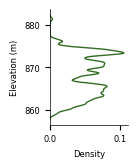

In [35]:
import seaborn as sns

# Define the output file path 
icesat2_profile_path = os.path.join(dir_figures, 'GediIcesat',
                                  'icesat2_profile.tif')

# Define your desired bin size
bin_size = 0.08  # Customize the bin size as needed

# Create a kernel density plot of 'height' values using Seaborn with custom bandwidth (bin size)
sns.kdeplot(
    y = filtered_icesat2_clip['height'], 
    bw_method = bin_size, 
    fill=False,
    lw=1.0,
    color='#346B23'
)

# Customize the plot as needed
plt.xlabel('Density')
plt.ylabel('Elevation (m)')  # Adjust the y-axis label




# Define the desired font size (8 points)
font_size = 7

# Set global font size for titles, labels, and tick labels
plt.rcParams.update({'font.size': font_size})

# Set the figure size (in inches)
fig_width = 1
fig_height = 1.5
plt.gcf().set_size_inches(fig_width, fig_height)


# Remove the right and top borders
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust the line width of the left and bottom borders
ax.spines['left'].set_linewidth(0.5)  # Set a thinner line width
ax.spines['bottom'].set_linewidth(0.5)  # Set a thinner line width

# Set the DPI to 300 (dots per inch)
dpi = 300



# Export the plot as a TIFF image with custom settings
plt.savefig(icesat2_profile_path, dpi=dpi, bbox_inches='tight', format='tiff')



# Display the plot
plt.show()

In [41]:
## Identify track in the plot 

In [42]:
# Check unique values in the 'rgt' column
unique_rgt = icesat2_track['rgt'].unique()

# Check unique values in the 'track' column
unique_track = icesat2_track['track'].unique()

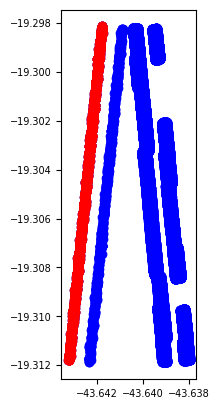

In [43]:
selected_track = icesat2_track = reduce_dataframe(icesat_tracks, 
                                 RGT=711, 
                                 track=2, 
                                 beam='strong'
                                )
# D3.crs
# Plot the first GeoDataFrame ('icesat_tracks') with a specified color (e.g., blue)
icesat_tracks.plot(ax=plt.gca(), color='blue', label='icesat_tracks')

# Plot the second GeoDataFrame ('icesat2_track') with a different color (e.g., red)
selected_track.plot(ax=plt.gca(), color='red', label='icesat2_track')


# Display the plot
plt.show()